In [23]:
from jfit import *
from jplot import *
from jFermi2.ImgAnalysis.SingleSiteAnalysis import *
import glob

import warnings
warnings.filterwarnings('ignore')

In [24]:
########################
### Helper Functions ###
########################
def load_imgs(run_name):
    # Load images
    img1 = np.loadtxt(os.path.join('Data', run_name+'_binned1.txt'))
    img2 = np.loadtxt(os.path.join('Data', run_name+'_binned2.txt'))
    # Find COM and shift the images
    img = img1+img2
    _x0, _y0 = get_com(img)
    _dim_x, _dim_y = img.shape
    img1_s = scipy.ndimage.shift(img1, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    img2_s = scipy.ndimage.shift(img2, (-(_x0-_dim_x/2.), -(_y0-_dim_y/2.)), order=0, mode='constant', cval=0)
    return img1_s, img2_s

def show_stats(df):
    def plot_hist(df, ax, variables, xrange, resolution):
        for ii, _var in enumerate(variables):
            x0, x1 = xrange
            nx = int((x1-x0)/resolution)
            *_, = ax.hist(df[_var], bins=np.linspace(x0, x1, nx), rwidth=0.5, alpha=0.75, align='left')
        setlabels(ax, [', '.join(variables), ''])
        
    fig, axs = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
    axs = axs.ravel()
    plot_hist(df, axs[0], ['com_x', 'com_y'], xrange=[40, 60], resolution=1)
    plot_hist(df, axs[1], ['N'], xrange=[200, 400], resolution=10)
    plot_hist(df, axs[2], ['Nd'], xrange=[20, 50], resolution=5)
    plot_hist(df, axs[3], ['imbal_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[4], ['imbal_s_corr'], xrange=[-0.6, 0.6], resolution=0.025)
    plot_hist(df, axs[5], ['PSF_width_1', 'PSF_width_2'], xrange=[0, 7], resolution=0.25)
    plot_hist(df, axs[6], ['fluor_pk_1', 'fluor_pk_2'], xrange=[400, 1000], resolution=25)
    plot_hist(df, axs[7], ['N1_loss_bri', 'N2_loss_bri'], xrange=[0, 0.3], resolution=0.01)
    plot_hist(df, axs[8], ['N1_hop_bri', 'N2_hop_bri'], xrange=[0, 0.1], resolution=0.005)
    plot_hist(df, axs[9], ['frac_misid_1', 'frac_misid_2'], xrange=[0, 0.3], resolution=0.005)
    plt.show()
    
def load_all_imgs(df):
    imgs = []
    for ii, _id in enumerate(df.index):
        img_up, img_dn = load_imgs(df.loc[_id, 'Run Name'][:-5])
        img_h, img_s, img_d, img_n = get_n_img(img_up+img_dn, [0, 1, 2])
        imgs.append([img_up, img_dn, img_h, img_s, img_d, img_n, img_up-img_d,img_dn-img_d,img_up-img_dn])
    imgs = dict(zip(['up', 'dn', 'h', 's', 'd', 'n', 's_up', 's_dn','p'], np.array(imgs).transpose((1, 0, 2, 3))))
    return imgs

def get_symmetry_permutation(d):
    _d = d
    rx = [[-1, 0], [0, 1]]
    rx = [[1, 0], [0, -1]]
    c4 = [[0, -1], [1, 0]]
    for ii in range(2):
        _d = np.dot(rx, _d)
        for jj in range(4):
            yield list(_d)
            _d  = np.dot(c4, _d)

def get_c_SymImgArrs(arrs, d_max):
    # Generates an array of 2D images with the connected correlator at displacement d at each point in the image, for each d 
    img_dim = np.array(arrs).shape[2:]    
    _ds, _c_arrs = [], []
    for ii in range(d_max+1):
        for jj in range(ii+1):
#             _d_sym = []
#             _ = [_d_sym.append(_item) for _item in get_symmetry_permutation([ii, jj]) if _item not in _d_sym]
            
#             _arr1, _arr2 = np.empty((0, *img_dim)), np.empty((0, *img_dim))
#             for _d in _d_sym:
#                 _arr1 = np.append(arrs[0], _arr1, axis=0)
#                 _arr2 = np.append(scipy.ndimage.shift(arrs[1], [0]+_d), _arr2, axis=0)
            
#             _c = correlation([_arr1, _arr2], [[0, 0], [0, 0]])
            _c, *_,  = get_cij(*arrs, [ii, jj])
            _c_arrs.append(_c)
            _ds.append([ii, jj])
    _rs = [np.sqrt(_d[0]**2+_d[1]**2) for _d in _ds]
    return _ds,_rs,_c_arrs

def build_cmat(d, c):
    d_max = int(np.max(d))
    cmat = np.zeros((2*d_max+1, 2*d_max+1))
    for ii, _d in enumerate(d):
        for _d_sym in get_symmetry_permutation(_d):
            _i, _j  = _d_sym
            cmat[_i+d_max, _j+d_max] = c[ii]
    return cmat

def build_c_sum(_d_arr, _r_arr, _c_arr):
    # returns sum of c values at radius less than or equal to d location, taking into account symmetry/degeneracy of rotation
    _deg = [len(np.unique(list(get_symmetry_permutation(_d)), axis=0)) for _d in _d_arr]
    _c_arr_degCorr = np.array([_c_arr[ii]*_deg[ii] for ii in range(len(_deg))])
    _c_sum_arr = np.array([np.sum(_c_arr_degCorr[np.where(_r_arr<=_r)], axis=0) for _r in _r_arr])
    return _c_sum_arr

# Extract binned density values 
def extract_binned_vals_in_img(_chop_mask, _img): # Takes value from only area in chop mask 
    _, _, binned_val, binned_err = bin_average(_chop_mask, _img, bin_num=2)
    return binned_val[-1], binned_err[-1] 
def extract_binned_vals_in_d_arr(_chop_mask, _img_arr, _d_arr):
    _arr_vals, _arr_errs = [], []
    for _id, _d in enumerate(_d_arr):
        _img_val, _img_err = extract_binned_vals_in_img(_chop_mask, _img_arr[_id])
        _arr_vals.append(_img_val)
        _arr_errs.append(_img_err)
    return _arr_vals, _arr_errs 

def gen_chop_mask_radial_arr(rMax,numRadBins, _img):
    # Generates an array of chop mask images which are equal area out to rMax
    rSqArr = np.linspace(0, rMax**2, numRadBins+1, endpoint=True)
    rArr = np.sqrt(rSqArr)
    drArr = np.diff(rArr)
    
    chop_mask_arr = []
    for _ir, dr in enumerate(drArr):
        r_min = rArr[_ir]; r_max = rArr[_ir+1]

        # Build chopping mask
        _dim1, _dim2 = _img.shape
        _dim1c = np.round(_dim1/2).astype(int); _dim2c = np.round(_dim2/2).astype(int)
        chop_mask_outer = np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)<=r_max, 1, 0), (_dim1, _dim2))
        chop_mask_arr.append(np.fromfunction(lambda x, y: np.where(np.sqrt((x-_dim1c)**2+(y-_dim2c)**2)>=r_min, chop_mask_outer, 0), (_dim1, _dim2)))
    return np.asarray(chop_mask_arr)

In [25]:
def postProcessDataAndPlot(d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg): 
    n_val, n_err = extract_binned_vals_in_img(chop_mask, img_n_avg)
    n1_val, n1_err = extract_binned_vals_in_img(chop_mask, img_n1_avg)
    n2_val, n2_err = extract_binned_vals_in_img(chop_mask, img_n2_avg)
    # Extract binned correlator values 
    c_vals, c_errs = extract_binned_vals_in_d_arr(chop_mask, c_arr, d_arr)
    c_sum_vals, c_sum_errs = extract_binned_vals_in_d_arr(chop_mask, c_sum_arr, d_arr)
    # Build correlation matrix 
    cmat = build_cmat(d_arr, c_vals)
    c_summat = build_cmat(d_arr, c_sum_vals)
    
    print("<n> = {:.3f} +/- {:.3f}".format(n_val, n_err))
    
    # Plotting result
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), constrained_layout=True)
    g2pltScale = 1.3*np.max(np.abs(c_vals[1:]/(n1_val*n2_val)))
    pCondpltScaleMid = c_sum_vals[0]/(n1_val)
    pCondpltScaleDelta = 1.3*np.max(np.abs(c_sum_vals[1:]/(n1_val)-pCondpltScaleMid))
    # Plot
    axs[0].imshow(cmat/(n1_val*n2_val)+1, cmap='RdBu_r', vmin=1-g2pltScale, vmax=1+g2pltScale)
    jerrbar(axs[1], r_arr, c_vals/(n1_val*n2_val)+1, yerr=c_vals/(n1_val*n2_val)*np.sqrt(np.divide(c_errs,c_vals)**2+(n1_err/n1_val)**2+(n2_err/n2_val)**2))
    jplot(axs[1], [r_arr[0], r_arr[-1]], [1, 1], ls='--', color='0.5')
    setlims(axs[1], None, [1-g2pltScale, 1 + g2pltScale])
    setlabels(axs[1], ["r [sites]", "g2("+ str(key[0])+","+str(key[1])+")"])
    axs[2].imshow(c_summat/n1_val, cmap='RdBu_r', vmin=pCondpltScaleMid-pCondpltScaleDelta, vmax=pCondpltScaleMid+pCondpltScaleDelta)
    jerrbar(axs[3], r_arr, c_sum_vals/n1_val, yerr=(c_sum_vals/n1_val)*np.sqrt(np.divide(c_sum_errs,c_sum_vals)**2+(n1_err/n1_val)**2))
    jplot(axs[3], [r_arr[0], r_arr[-1]], [c_sum_vals[0]/n1_val, c_sum_vals[0]/n1_val], ls='--', color='0.5')
    setlims(axs[3], None, [pCondpltScaleMid-pCondpltScaleDelta,pCondpltScaleMid+pCondpltScaleDelta])
    setlabels(axs[3], ["r [sites]", "Sum(Cond. Prob. of "+str(key[1])+" at x for x<=r)"])
    plt.show()
    
    # # Try other density binning for conditional probability
    # frac_nCorrection = 0.2
    # img_n1_avg_InfCorrectec = (img_n1_avg*(1-frac_nCorrection) + n1_val*frac_nCorrection)
    # pCond_sum_vals, pCond__sum_errs = extract_binned_vals_in_d_arr(chop_mask, c_sum_arr/img_n1_avg_InfCorrectec, d_arr)
    # jerrbar(axs[4], r_arr, pCond_sum_vals, yerr=pCond__sum_errs)
    # jplot(axs[4], [r_arr[0], r_arr[-1]], [c_sum_vals[0]/n1_val, c_sum_vals[0]/n1_val], ls='--', color='0.5')
    # setlims(axs[4], None, [pCondpltScaleMid-pCondpltScaleDelta,pCondpltScaleMid+pCondpltScaleDelta])
    # setlabels(axs[4], ["r [sites]", "Sum(Cond. Prob. of "+str(key[1])+" at x for x<=r)"])

# TOF analysis

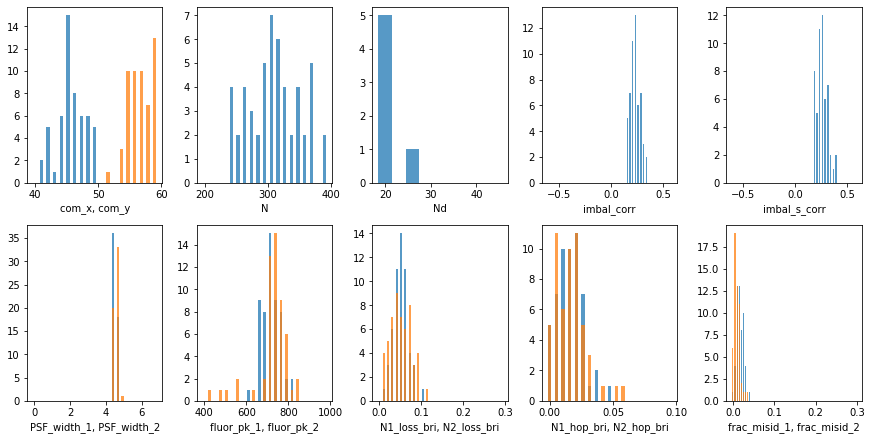

Image number after post selection:  54


In [26]:
tag = 'test7'
nMin = 0; nMax = 500
ndMin = 0; ndMax = 60
imbalMin = -1; imbalMax = 1

df = pd.read_csv(glob.glob('*.csv')[0])
df = df[(df['Tag']==tag)&(df['Valid']==1)]
show_stats(df)
_df = df
_df = _df[(_df['N']>=nMin)&(_df['N']<=nMax)]
_df = _df[(_df['Nd']>=ndMin)&(_df['Nd']<=ndMax)]
_df = _df[(_df['imbal_corr']>=imbalMin)&(_df['imbal_corr']<=imbalMax)]
imgs = load_all_imgs(_df)
print("Image number after post selection: ",len(_df))

In [30]:
# Global parameters for analysis/plots
d_max_glob = 7
rMaxChop_glob = 40
numChopBins_glob = 4

<n> = 0.117 +/- 0.001


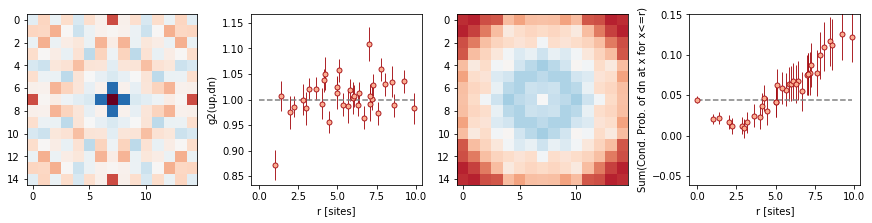

<n> = 0.079 +/- 0.001


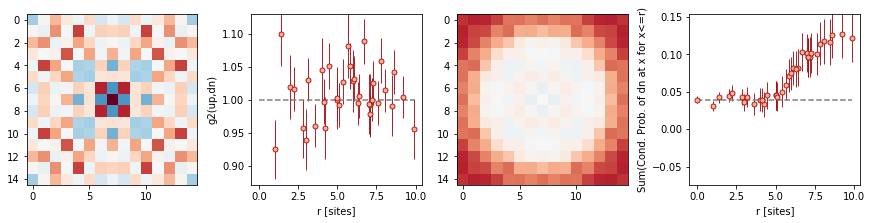

<n> = 0.043 +/- 0.001


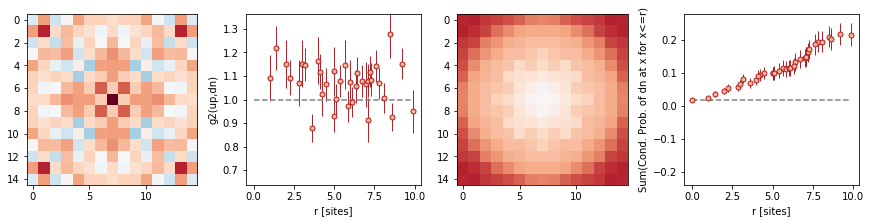

<n> = 0.013 +/- 0.000


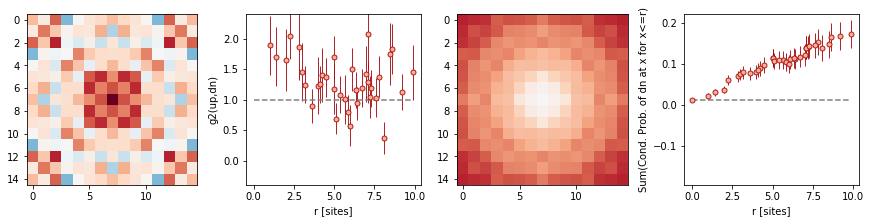

In [31]:
key= ['up','dn']

# Generate data (takes a long time, but can be run separately first and then plotting later)
d_arr, r_arr, c_arr = get_c_SymImgArrs([imgs[key[0]], imgs[key[1]]], d_max=d_max_glob) # Array of 2D Images with connected correlator at that location, for each d
c_sum_arr = build_c_sum(d_arr, r_arr, c_arr)

# Average density images
img_n_avg = np.average(imgs['n'], axis=0)
img_n1_avg = np.average(imgs[key[0]], axis=0)
img_n2_avg = np.average(imgs[key[1]], axis=0)

# Generate plots (can be done separately)
chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, img_n_avg)
for chop_mask in chop_mask_arr:
    postProcessDataAndPlot(d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg)

<n> = 0.117 +/- 0.001


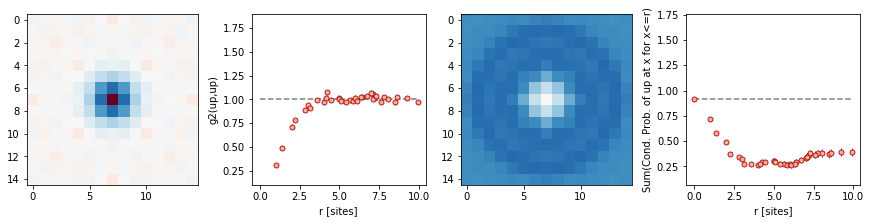

<n> = 0.079 +/- 0.001


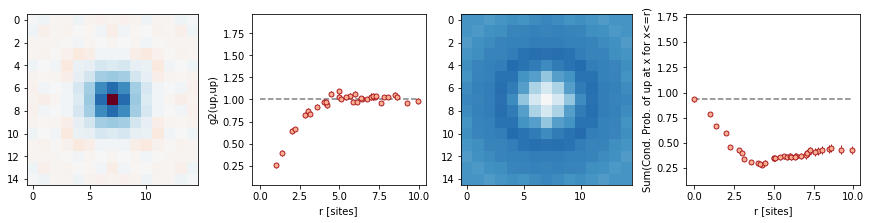

<n> = 0.043 +/- 0.001


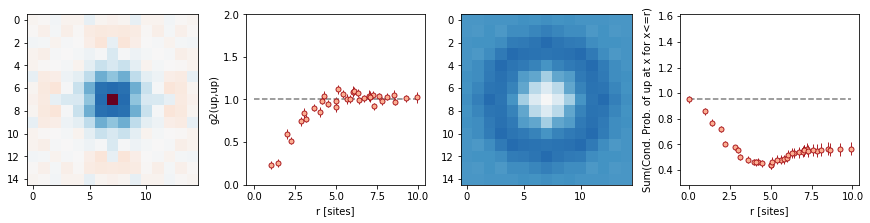

<n> = 0.013 +/- 0.000


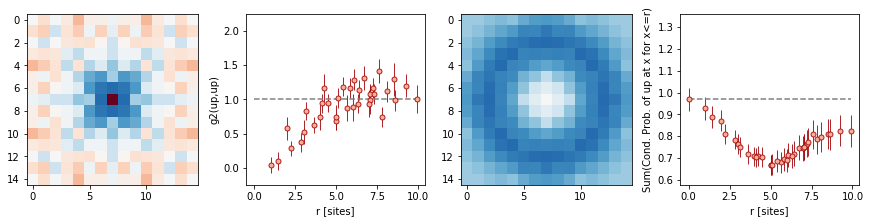

In [32]:
key= ['up','up']

# Generate data (takes a long time, but can be run separately first and then plotting later)
d_arr, r_arr, c_arr = get_c_SymImgArrs([imgs[key[0]], imgs[key[1]]], d_max=d_max_glob) # Array of 2D Images with connected correlator at that location, for each d
c_sum_arr = build_c_sum(d_arr, r_arr, c_arr)

# Average density images
img_n_avg = np.average(imgs['n'], axis=0)
img_n1_avg = np.average(imgs[key[0]], axis=0)
img_n2_avg = np.average(imgs[key[1]], axis=0)

# Generate plots (can be done separately)
chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, img_n_avg)
for chop_mask in chop_mask_arr:
    postProcessDataAndPlot(d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg)

<n> = 0.117 +/- 0.001


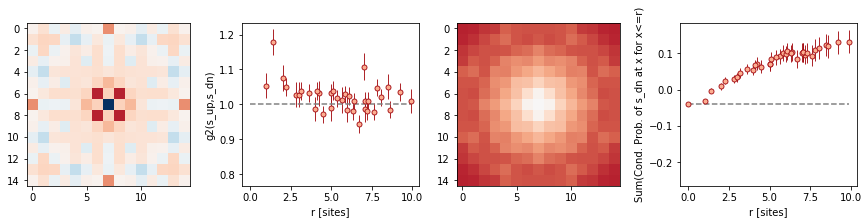

<n> = 0.079 +/- 0.001


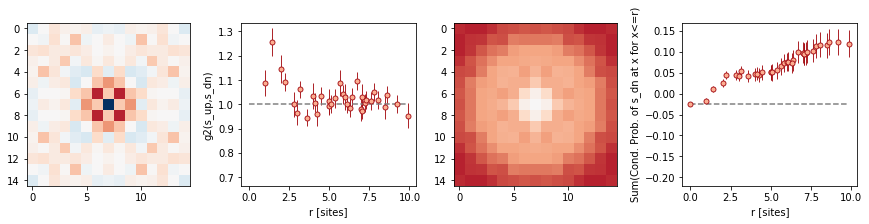

<n> = 0.043 +/- 0.001


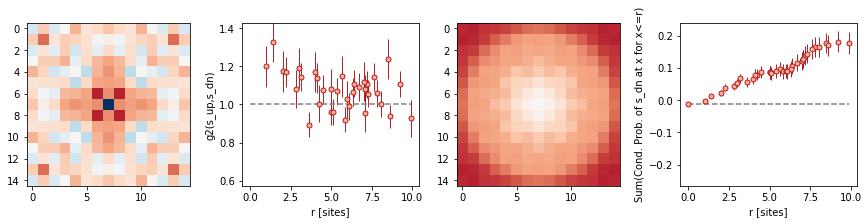

<n> = 0.013 +/- 0.000


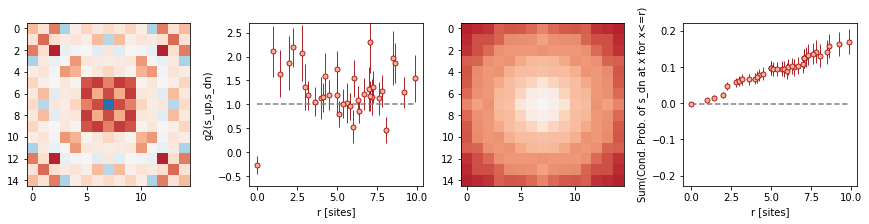

In [33]:
key= ['s_up','s_dn']

# Generate data (takes a long time, but can be run separately first and then plotting later)
d_arr, r_arr, c_arr = get_c_SymImgArrs([imgs[key[0]], imgs[key[1]]], d_max=d_max_glob) # Array of 2D Images with connected correlator at that location, for each d
c_sum_arr = build_c_sum(d_arr, r_arr, c_arr)

# Average density images
img_n_avg = np.average(imgs['n'], axis=0)
img_n1_avg = np.average(imgs[key[0]], axis=0)
img_n2_avg = np.average(imgs[key[1]], axis=0)

# Generate plots (can be done separately)
chop_mask_arr = gen_chop_mask_radial_arr(rMaxChop_glob,numChopBins_glob, img_n_avg)
for chop_mask in chop_mask_arr:
    postProcessDataAndPlot(d_arr, r_arr, c_arr, c_sum_arr, chop_mask, img_n_avg, img_n1_avg, img_n2_avg)